## Multiclass Image Classification Project

### Challenge - PokeMon's on Goa Trip

**Description** - You are going on a trip to Dudhsagar Falls, Goa. To reach the falls you have to cross a huge forest in Collem, so you thought of entering the forest. While you are on your route you spotted multiple Pokemons like Bulbasaur, Pikachu, and Charmender. After coming back, you thought of making a PokeDex - a Pokemon Detector Device which classifies these Pokemons. Write an algorithm that classifies these PokeMons.

**Approach** - Classification of Pokemons using Multi-Layer Perceptron from scratch.

In [1]:
import numpy as np
from keras.preprocessing import image
import os
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [617]:
## Training Data

path = Path("Train")  ## Path of the directory containing the folders with images - training data
dirs = path.glob("*")   ## Directories within the path

labels_encoded = {"Pikachu":0, "Bulbasaur":1, "Charmander":2} ## encoding the categories in the dictionary - labels
label2pokemon = {0:"Pikachu",1:"Bulbasaur",2:"Charmander"}

image_data = []
labels = []

for folder in dirs:
    label = str(folder).split("\\")[1]
    
    for img_path in folder.glob("*.jpg"):
        img = image.load_img(img_path, target_size=(40,40))  ## Load every image with size = 40x40
        img_array = image.img_to_array(img)  ## Convert the image into a 40,40,3 array (RGB)
        image_data.append(img_array)         ## Append the array to the list of image_data
        labels.append(labels_encoded[label]) ## Store the label for the given image

c:\users\kanav mehra\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [618]:
## Testing Data

test_path = Path("Test")  ## Path of the directory containing the folders with images - testing data
test_dirs = test_path.glob("*")   ## Directories within the test path

test_data = []
file_names = []

for folder in test_dirs:
    for img_path in folder.glob("*.jpg"):
        file_names.append(img_path.name)
        img = image.load_img(img_path, target_size=(40,40))  ## Load every image with size = 40x40
        img_array = image.img_to_array(img)  ## Convert the image into a 40,40,3 array (RGB)
        test_data.append(img_array)         ## Append the array to the list of image_data

### Random Shuffling of Data for Training Purpose

In [619]:
import random
from sklearn.utils import shuffle

random.seed(10)

X = np.array(image_data)
Y = np.array(labels)
X,Y = shuffle(X,Y,random_state=27)

X_test = np.array(test_data)

# Normalisation of pixel values
X = X/255.0
X_test = X_test/255.0

In [620]:
print(X.shape)
print(Y.shape)
print(X_test.shape)

(304, 40, 40, 3)
(304,)
(123, 40, 40, 3)


### View Image

In [621]:
def plotImage(img, label):
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
    plt.show()

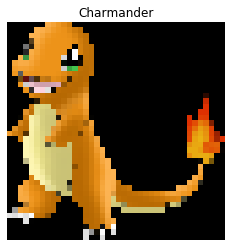

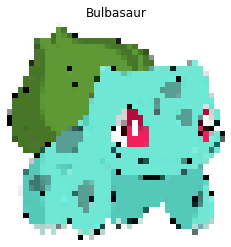

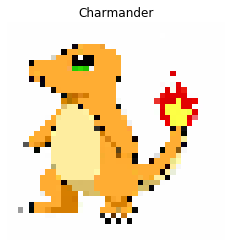

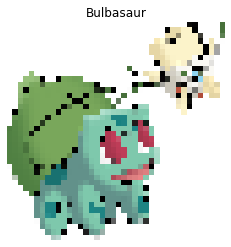

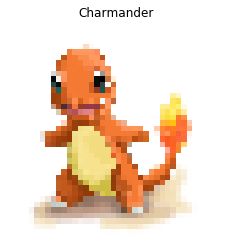

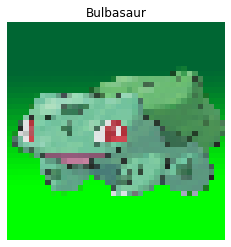

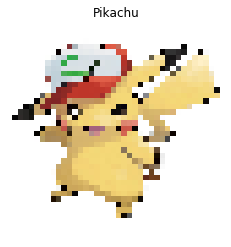

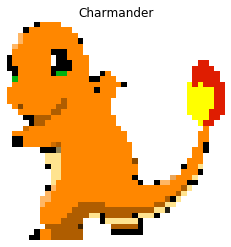

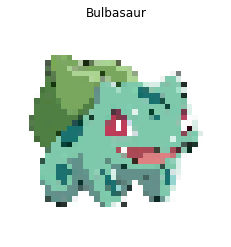

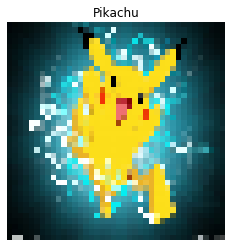

In [623]:
for i in range(10):
    plotImage(X[i].reshape(40,40,3), label2pokemon[Y[i]])

### Reshape Data

In [624]:
## Flatten the 40x40x3 array into a single dimensional array

no_of_samples_train = X.shape[0]
no_of_samples_test = X_test.shape[0]

X = X.reshape(no_of_samples_train,-1)
print(X.shape)

X_test = X_test.reshape(no_of_samples_test,-1)
print(X_test.shape)

(304, 4800)
(123, 4800)


In [625]:
### Create Training and Validation Set

split = int(X.shape[0]*0.75)

X_ = np.array(X)
Y_ = np.array(Y)

#Training Set
X = X_[:split,:]
Y = Y_[:split]

#Validation Set
X_Val = X_[split:,:]
Y_Val = Y_[split:]

print(X.shape,Y.shape)
print(X_Val.shape,Y_Val.shape)

(228, 4800) (228,)
(76, 4800) (76,)


In [626]:
## Model Parameters

INPUT_SIZE = 4800 ## no_of_features
LAYERS = [35, 20] ## No.of Neurons in each hidden layer
OUTPUT_SIZE = 3 ## No.of Classes

In [627]:
def softmax(a):
    '''Implementing the Softmax layer function'''
    
    e_pa = np.exp(a)
    smax = e_pa/np.sum(e_pa, axis=1, keepdims=True)
    return smax

In [628]:
class NeuralNetwork:
    
    def __init__(self, input_size, layers, output_size):
        '''Constructor to initialize the members of the class'''
        
        model = {} ## Dictionary to store the parameters of the network
        np.random.seed(0)
                
        ## Iterate over the layers and store the parameters in the dictionary for each layer
        for lx in range(len(layers)):
            
            idx = str(lx+1)
            
            if lx==0:
                model['W'+idx] = np.random.randn(input_size, layers[lx])
                model['b'+idx] = np.zeros((1, layers[lx]))
            
            else:
                model['W'+idx] = np.random.randn(layers[lx-1], layers[lx])
                model['b'+idx] = np.zeros((1, layers[lx]))
        
        idx = str(len(layers)+1)
        model['W'+idx] = np.random.randn(layers[-1], output_size)
        model['b'+idx] = np.zeros((1, output_size))
        
        self.model = model
        self.activation_outputs = None
        
    def forward(self, X):
        '''Implementation of Forward Propagation'''
        
        Z = []
        A = []
        layers = int(len(self.model)/2) ## Getting total no.of layers including Output layer
        
        for ix in range(layers):
            
            idx = str(ix+1)
            W = self.model['W'+idx]
            b = self.model['b'+idx]
            
            if ix==0:
                a = X
            else:
                a = A[ix-1]
                
            z = np.dot(a, W) + b
            a_ = np.tanh(z)  ## Activation function -> tanh
            
            Z.append(z)
            A.append(a_)
        
        y_ = softmax(Z[-1])  ## Translate to probabilities for classes
        A[-1] = y_
        
        self.activation_outputs = A
        return y_
    
    def backward(self, X, Y, learning_rate=0.001):
        '''Implementation of Backpropagation using Binary Cross Entropy as loss function'''
        
        activations = self.activation_outputs
        M = X.shape[0]  ## No.of examples
        
        gradients_w = [] ## Store weight gradients for each layer
        gradients_b = [] ## Store bias gradients for each layer
        deltas = [] ## Store delta values for each layer
        
        layers = int(len(self.model)/2) ## Getting total no.of layers including Output Layer
        
        for ix in range(layers,0,-1):
            
            a = activations[ix-1]
            idx = str(ix+1)
            
            if ix==1:
                a_prev = X
            else:
                a_prev = activations[ix-2]
            
            ## Gradients for output layer
            if ix==layers:
                delta = a - Y
                dw = np.dot(a_prev.T, delta)
                db = np.sum(delta, axis=0)
            
            else:
                delta = (1-np.square(a))*np.dot(deltas[0], self.model['W'+idx].T)
                dw = np.dot(a_prev.T, delta)
                db = np.sum(delta, axis=0)
                
            deltas.insert(0,delta)
            gradients_w.insert(0,dw)
            gradients_b.insert(0,db)
        
        for ix in range(layers):
            idx = str(ix+1)
            self.model['W'+idx] -= learning_rate*gradients_w[ix]
            self.model['b'+idx] -= learning_rate*gradients_b[ix]
            
    def predict(self, X):
        '''Prediction for a given value of X'''
        
        y_out = self.forward(X)
        return np.argmax(y_out, axis=1)
    
    def summary(self):
        '''Prints the summary of the model - Shapes of all Parameters in every layer'''
        
        layers = int(len(self.model)/2) ## Getting total no.of layers including Output Layer
        
        for ix in range(layers):
            idx = str(ix+1)
            print("W"+idx, self.model["W"+idx].shape)
            print("b"+idx, self.model["b"+idx].shape)
            print("A"+idx, self.activation_outputs[ix].shape)

### Loss Function

In [629]:
def loss(Y_oht, probs):
    '''Computing the loss using Cross Entropy function'''
    
    val = -np.mean(Y_oht*np.log(probs))
    return val

def one_hot(Y, depth):
    '''One-Hot encoding of the Y Label vector. Variable depth = no.of classes'''
    
    M = Y.shape[0]  ## No.of samples
    Y_oht = np.zeros((M, depth))
    Y_oht[np.arange(M), Y] = 1
    return Y_oht

### Training the Model

In [630]:
def train(X, Y, model, epochs=700, learning_rate=0.0002, logs=True):
    '''Train the model and visualise the loss'''
    
    training_loss = [] ## To store the loss values for each iteration
    classes = len(np.unique(Y))
    Y_oht = one_hot(Y, classes) ## One hot encoding of the labels for every example
    
    for ix in range(epochs):
        
        Y_ = model.forward(X)  ## Get the predictions from forward propagation
        loss_val = loss(Y_oht, Y_)
        training_loss.append(loss_val)
        model.backward(X, Y_oht, learning_rate)  ## Backpropagation to modify the paramters
        if(logs and ix%50==0):
            print("Epoch %d Loss %.4f"%(ix,loss_val))
        
    return training_loss

In [631]:
model = NeuralNetwork(input_size=INPUT_SIZE, layers=LAYERS, output_size=OUTPUT_SIZE)

In [632]:
print(X.shape)
print(X_test.shape)
print(X_Val.shape)

(228, 4800)
(123, 4800)
(76, 4800)


In [633]:
losses = train(X, Y, model)  ## Training the Model

Epoch 0 Loss 1.1712
Epoch 50 Loss 0.3194
Epoch 100 Loss 0.2540
Epoch 150 Loss 0.2114
Epoch 200 Loss 0.1871
Epoch 250 Loss 0.1712
Epoch 300 Loss 0.1532
Epoch 350 Loss 0.1432
Epoch 400 Loss 0.1347
Epoch 450 Loss 0.1271
Epoch 500 Loss 0.1201
Epoch 550 Loss 0.1136
Epoch 600 Loss 0.1059
Epoch 650 Loss 0.1001


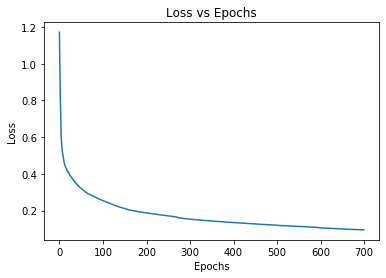

In [635]:
plt.plot(losses)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [636]:
model.summary()  ## Summary of Model Parameters

W1 (4800, 35)
b1 (1, 35)
A1 (228, 35)
W2 (35, 20)
b2 (1, 20)
A2 (228, 20)
W3 (20, 3)
b3 (1, 3)
A3 (228, 3)


### Calculating Training and Validation Accuracy

In [637]:
# Accuracy 
def getAccuracy(X,Y,model):
    outputs = model.predict(X)
    acc = np.sum(outputs==Y)/Y.shape[0]
    return acc
    
print("Train Acc = %.4f"%getAccuracy(X,Y,model))
print("Validation Acc = %.4f"%getAccuracy(X_Val,Y_Val,model))

Train Acc = 0.9035
Validation Acc = 0.7237


### Analyzing the Results - Training Set

In [638]:
from sklearn.metrics import confusion_matrix, classification_report
from visualize import plot_confusion_matrix

Confusion matrix, without normalization
[[68  3  8]
 [ 4 69  2]
 [ 5  0 69]]


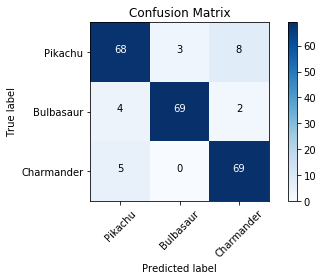

In [639]:
plot_confusion_matrix(cnf_matrix,classes=["Pikachu","Bulbasaur","Charmander"],title="Confusion Matrix")

In [640]:
print(classification_report(model.predict(X), Y))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87        79
           1       0.96      0.92      0.94        75
           2       0.87      0.93      0.90        74

    accuracy                           0.90       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.90      0.90      0.90       228



### Analyzing the Results - Validation Set

Confusion matrix, without normalization
[[18  7  4]
 [ 3 21  3]
 [ 3  1 16]]


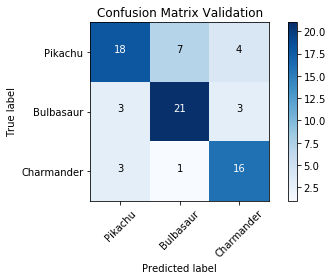

In [641]:
val_outputs = model.predict(X_Val)
cnf_matrix_val = confusion_matrix(val_outputs, Y_Val)
plot_confusion_matrix(cnf_matrix_val, classes=["Pikachu","Bulbasaur","Charmander"],title="Confusion Matrix Validation")

In [642]:
print(classification_report(val_outputs, Y_Val))

              precision    recall  f1-score   support

           0       0.75      0.62      0.68        29
           1       0.72      0.78      0.75        27
           2       0.70      0.80      0.74        20

    accuracy                           0.72        76
   macro avg       0.72      0.73      0.72        76
weighted avg       0.73      0.72      0.72        76



### Visualizing Misclassifications!

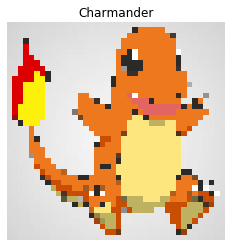

   Prediction - Pikachu


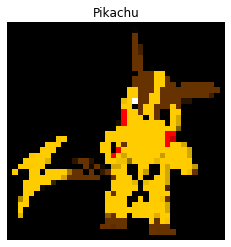

   Prediction - Charmander


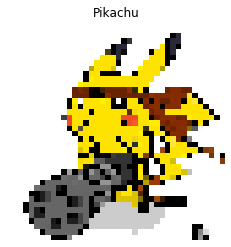

   Prediction - Bulbasaur


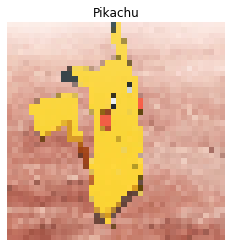

   Prediction - Bulbasaur


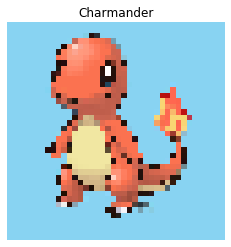

   Prediction - Pikachu


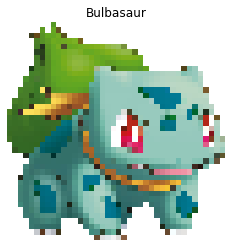

   Prediction - Pikachu


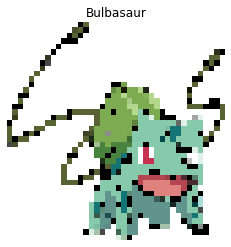

   Prediction - Pikachu


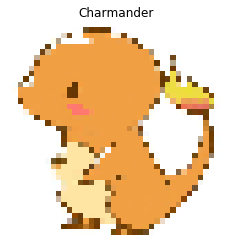

   Prediction - Bulbasaur


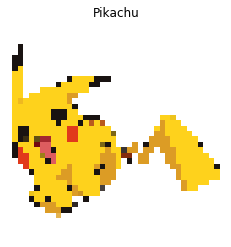

   Prediction - Bulbasaur


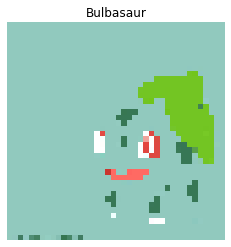

   Prediction - Pikachu


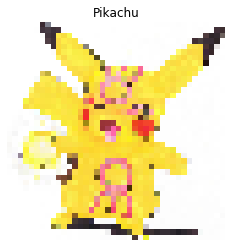

   Prediction - Charmander


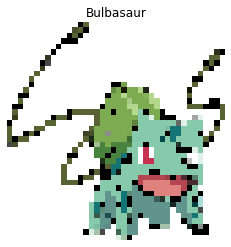

   Prediction - Pikachu


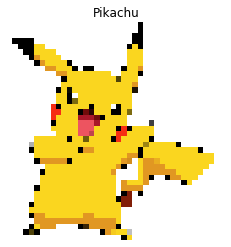

   Prediction - Charmander


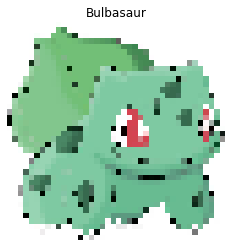

   Prediction - Pikachu


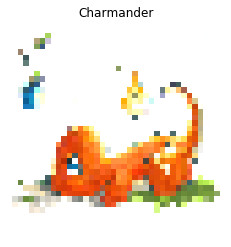

   Prediction - Bulbasaur


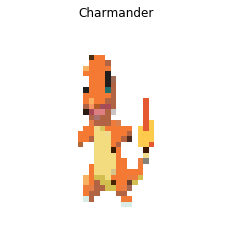

   Prediction - Pikachu


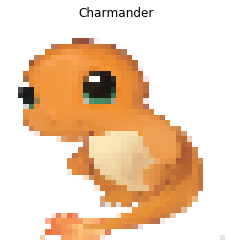

   Prediction - Pikachu


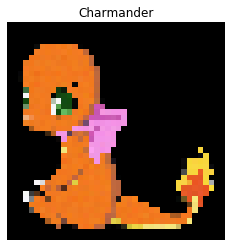

   Prediction - Bulbasaur


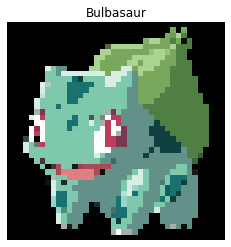

   Prediction - Pikachu


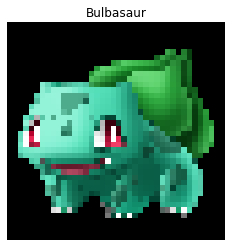

   Prediction - Charmander


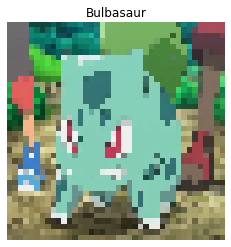

   Prediction - Pikachu


In [644]:
for i in range(Y_Val.shape[0]):
    if Y_Val[i] != val_outputs[i]:
        plotImage(X_Val[i].reshape(40,40,3),label2pokemon[Y_Val[i]])
        print("   Prediction - %s"%(label2pokemon[val_outputs[i]]))

### Classifying Test Data

In [645]:
y_predictions = model.predict(X_test)
y_predictions = np.array(y_predictions)
print(y_predictions)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 1 0 0 0 2 0 0 1 0 0 2 2 1 2 0 2 2 2
 0 0 0 0 1 2 0 2 2 2 2 2 2 2 2 2 1 2 2 2 0 0 0 2 2 1 2 0 0 2 2 2 0 2 2 2 2
 1 2 1 0 2 2 2 2 2 2 2 2]


In [646]:
predicted_labels = []

for val in y_predictions:
    predicted_labels.append(label2pokemon[val])
    
print(predicted_labels)

['Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Pikachu', 'Bulbasaur', 'Bulbasaur', 'Pikachu', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Charmander', 'Pikachu', 'Pikachu', 'Pikachu', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Pikachu', 'Charmander', 'Pikachu', 'Pikachu', 'Bulbasaur', 'Pikachu', 'Pikachu', 'Charmander', 'Charmander', 'Bulbasaur', 'Charmander', 'Pikachu', 'Charmander', 'Charmander', 'Charmander', 'Pikachu', 'Pikachu', 'Pikachu', 'Pikachu', 'Bulbasaur', 'Charmander', 'Pik

In [647]:
df_test = pd.read_csv('Test/test.csv')
image_ids = list(df_test['ImageId'])
y_values = []

for img in image_ids:
    idx = file_names.index(img)
    y_values.append(predicted_labels[idx])

In [648]:
output = pd.DataFrame({'ImageId':image_ids, 'NameOfPokemon': y_values})
output.to_csv('submission_mlp.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
